# Notebook for the inference of cell-cell communications on COPD-IAV data using `LIANA+` and Tensor cell2cell

- **Developed by**: Carlos Talavera-López, Christian Eger, and Camila Melo
- **Würzburg Institute for Systems Immunology, Faculty of Medicine, Julius-Maximilian-Universität Würzburg**
- **Created**: 231109
- **Latest version**: 240701

* [1. Environment setup](#1-environment-setup)
    * [1.1. Import required modules](#11-import-required-modules)
    * [1.2. Set up working environment](#12-set-up-working-environment)
    * [1.3. Helper functions](#13-helper-functions)
    * [1.4. Specify data directory](#14-specify-data-directory)
    * [1.5. Read in all data](#15-read-in-all-data)
    * [1.6. Logarithmic transformation of data](#16-logaritmic-transformation-of-data)
    * [1.7 Show pre-computed UMAP](#17-show-pre-computed-umap)
* [2. Intercellular context factorization with tensor cell2cell](#2-intercellular-context-factorization-with-tensor-cell2cell)
    * [2.1. Create Liana Dataset](#21-create-liana-datset)
        * [2.1.1. Run liana rank_aggregate.by_sample](#211-run-liana-rank_aggregateby_sample)
        * [2.1.2. Save/Read Liana output file](#212-saveread-liana-output-file)
    * [2.2. Build Tensor](#22-build-tensor)
        * [2.2.1 Run .to_tensor_c2c](#221-run-to_tensor_c2c)
        * [2.2.2. Save/Load initial Tensor](#222-saveload-initial-tensor)
    * [2.3. Running Tensor-cell2cell](#23-running-tensor-cell2cell)
* [3. Analysis](#3-analysis)

## 1. Environment setup

if your computer has a gpu:
```bash
mamba env create -f 6-cell-cell_comms/4-tensor/liana_c2c_cuda-env.yml 
mamba activate liana_c2c-env
```
if your computer doesn't have a gpu:
```bash
mamba env create -f 6-cell-cell_comms/4-tensor/liana_c2c-env.yml 
mamba activate liana_c2c-env
```

### 1.1 Import required modules

In [1]:
import anndata
import numpy as np
import pandas as p
import seaborn as sns
from scipy import stats
import liana as li
import scanpy as sc
import cell2cell as c2c
import decoupler as dc # needed for pathway analysis
from collections import defaultdict
import pickle
import torch
import io
import plotnine as p9
import decoupler as dc # needed for pathway analysis
#from statannotations.Annotator import Annotator
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean
import os
import omnipath as op
import pandas as pd
import matplotlib.pyplot as plt

/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### 1.2. Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.6
-----
PIL                 10.4.0
asttokens           NA
attr                23.2.0
backcall            0.2.0
brotli              1.1.0
cell2cell           0.7.4
certifi             2024.06.02
cffi                1.16.0
charset_normalizer  3.3.2
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.2
decorator           5.1.1
decoupler           1.6.0
docrep              0.3.2
executing           2.0.1
get_annotations     NA
h5py                3.11.0
idna                3.7
importlib_resources NA
inflect             NA
ipykernel           6.29.5
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
kneed               0.8.5
liana               1.2.1
llvmlite            0.41.1
matplotlib          3.7.5
mizani              0.9.3
more_itertools      10.3.0
mpl_toolkits        NA
mudata              0.2.3
natsort             8.4.0
networkx            3.

In [29]:
adata_all.obs['cell_compartment'].value_counts()

Basal           39735
Goblet          22087
SupraB          10999
Club             9055
Mixed            6258
Ciliated         3695
Secretory        3207
Epi              1452
Ionocyte          611
Deuterosomal      474
Name: cell_compartment, dtype: int64

### 1.3. Helper functions

In [3]:

def unpickle_gpu_tensor(filepath: str, processing_unit: str):
    '''
    Function to load a pickled tensor file created using cell2cell with gpu acceleration

    filepath: str = path of the tensor file
    processing_unit: str = processing_unit used in the current environment to load the file onto (either "gpu" or "cpu")
    '''
    class CPU_Unpickler(pickle.Unpickler):
        def find_class(self, module, name):
            if module == 'torch.storage' and name == '_load_from_bytes':
                return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
            else: return super().find_class(module, name)

    processing_unit_values = ['cpu', 'gpu']
    if processing_unit == 'cpu':
        with open(filepath, 'rb') as f:
            tensor = CPU_Unpickler(f).load()
    elif processing_unit == 'gpu':
        with open(filepath, 'rb') as f:
            tensor = pickle.load(f)
    else:
        raise ValueError(f'accelerator must be one of {processing_unit_values}')
    return tensor

### 1.4. Specify data directory

In [4]:
data_dir = os.path.join(os.getcwd(), '.data')
os.makedirs(data_dir, exist_ok=True)
os.listdir(data_dir)

['initial_tensor.pkl',
 'final_tensor.pkl',
 'anndata_liana.h5ad',
 'Marburg_cell_states_locked_ctl240709.raw.h5ad']

In [5]:
adata_path = os.path.join(data_dir, 'Marburg_cell_states_locked_ctl240709.raw.h5ad')

### 1.5. Read in all data

In [6]:
adata_all = sc.read_h5ad(adata_path) 
adata_all

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_umap'

In [7]:
sample_key = 'batch'
condition_key = 'group'
groupby = 'cell_states'

### 1.6. Logaritmic transformation of data

In [8]:
sc.pp.normalize_total(adata_all, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_all)

KeyboardInterrupt: 

### 1.7. Show pre-computed UMAP

/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


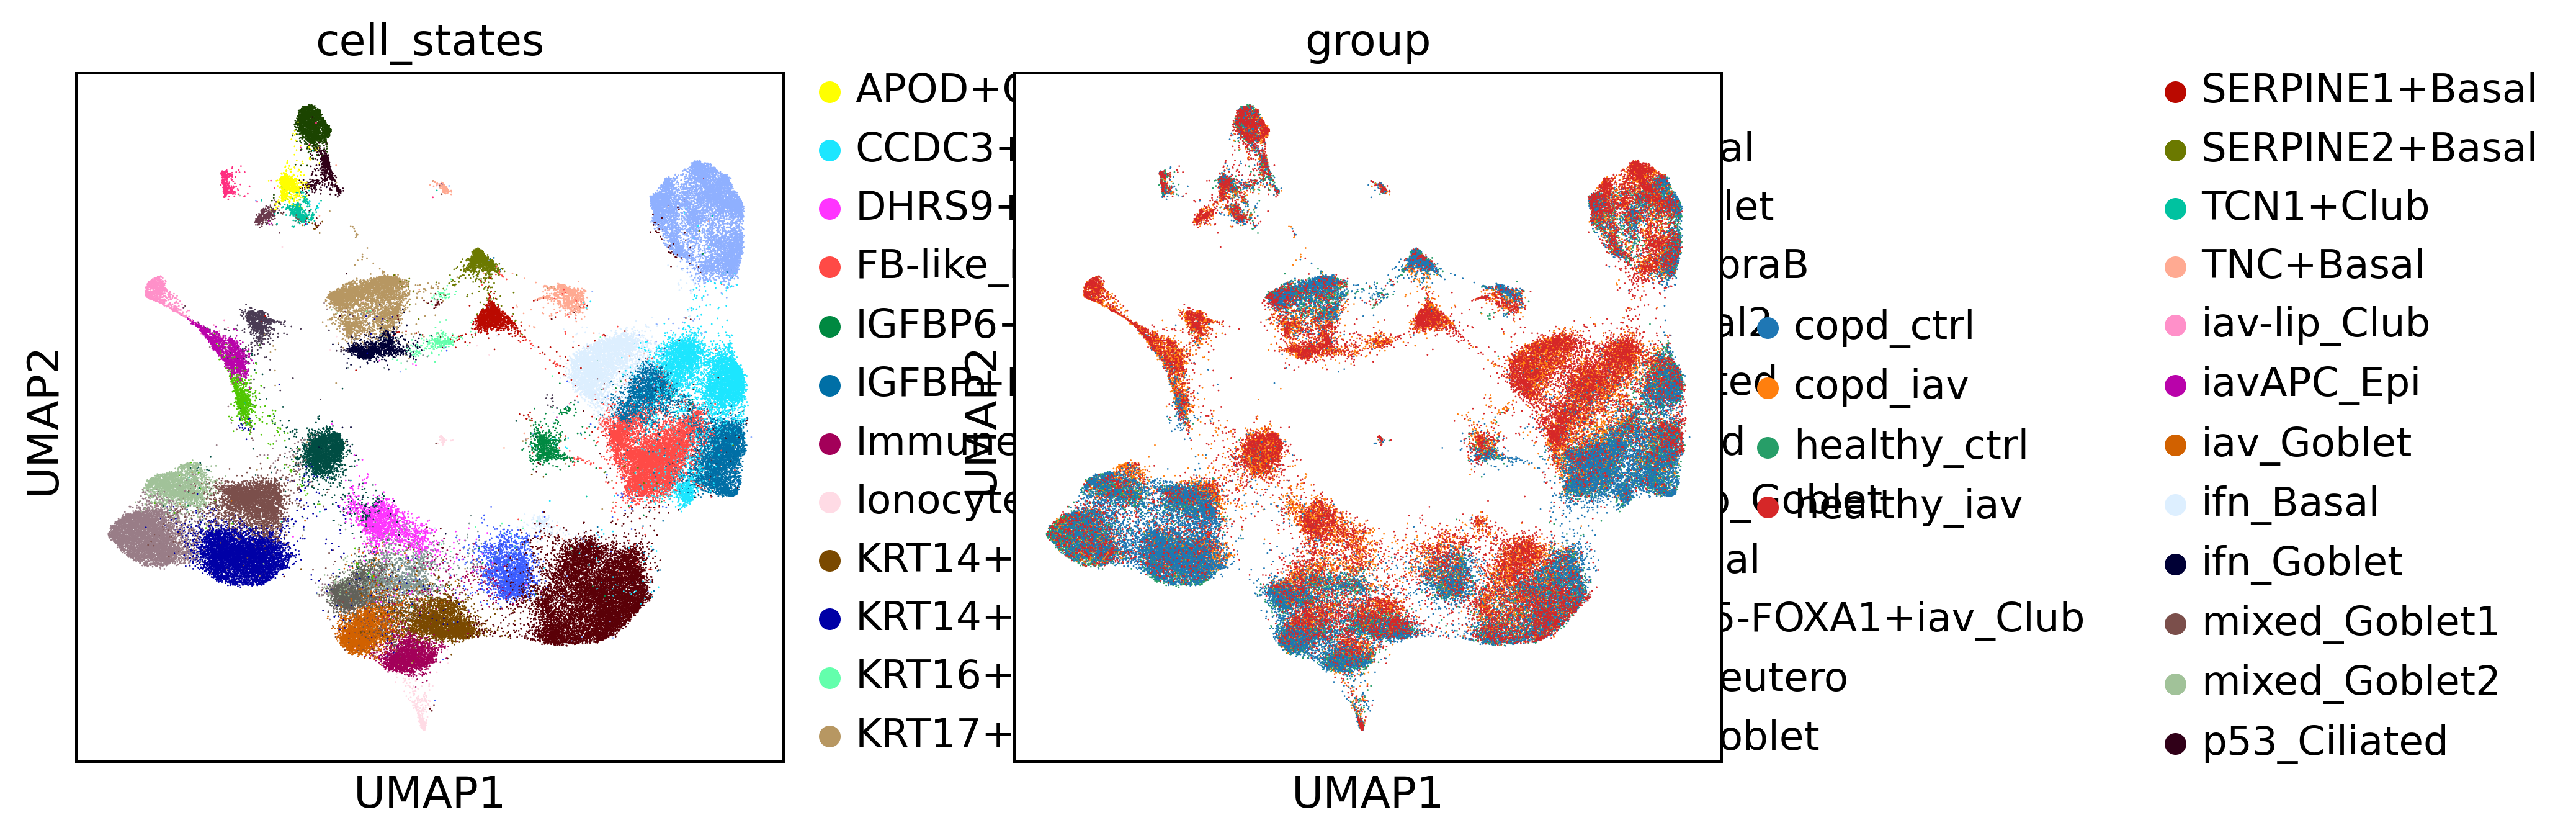

In [9]:
sc.pl.umap(adata_all, color=[groupby, condition_key],frameon=True)

## 2. Intercellular Context Factorization with Tensor-Cell2cell 

### 2.1. Create Liana Datset

#### 2.1.1. Run liana rank_aggregate.by_sample

In [ ]:
sample_key = 'batch'
condition_key = 'group'
groupby = 'cell_states'

In [ ]:
context_dict = adata_all.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)
context_dict

In [ ]:
li.mt.rank_aggregate.by_sample(
    adata_all,
    groupby=groupby,
    sample_key=sample_key, # sample key by which we which to loop
    use_raw=False,
    seed=1789,
    min_cells=5,
    verbose=True, # use 'full' to show all verbose information
    #n_perms=100, # reduce permutations for speed
    return_all_lrs=True, # return all LR values
    )


In [ ]:
adata_all.uns['liana_res'].sort_values("magnitude_rank").head(20)

#### 2.1.2. Save/Read Liana output file

In [ ]:
file_name = 'anndata_liana.h5ad'
file_path = os.path.join(data_dir, file_name)
# Write
adata_all.write_h5ad(file_path)
# Read
#adata_all = sc.read_h5ad(file_path)

### 2.2. Build Tensor

#### 2.2.1. Run .to_tensor_c2c

In [ ]:
tensor = li.multi.to_tensor_c2c(adata_all,
                                sample_key=sample_key,
                                score_key='magnitude_rank', # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )
tensor.tensor.shape

#### 2.2.2. Save/Load Initial Tensor

In [ ]:
file_name = 'initial_tensor.pkl'
file_path = os.path.join(data_dir, file_name)

# Save
c2c.io.export_variable_with_pickle(tensor, file_path)
# Load | 'cpu' or 'gpu' depending on the current environment
#tensor = unpickle_gpu_tensor(file_path, 'gpu')

### 2.3 Running Tensor-cell2cell

#### 2.3.1. Building Metadata

In [ ]:

context_dict = adata_all.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )


#### 2.3.2. Run run_tensor_cell2cell_pipeline()

In [ ]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=None, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=1789, # Random seed for reproducibility
                                                    backend='pytorch', # This enables a banckend that supports using a GPU.
                                                    device='cuda', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=25, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    fig_fontsize=14,
                                                    output_fig=True, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )

#### 2.3.3. Save/Load Tensor object

In [9]:
file_name = 'final_tensor.pkl'
file_path = os.path.join(data_dir, file_name)

# Save
#c2c.io.export_variable_with_pickle(tensor, file_path)
# Load
tensor = unpickle_gpu_tensor(file_path, 'cpu')

## 3. Analysis

### Enrichment analysis

In [10]:
# load PROGENy pathways
net = dc.get_progeny(organism='human', top=5000)

In [11]:

# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

In [12]:
factors = tensor.factors

In [13]:
factors.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

In [14]:
context_dict = adata_all.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)
# Generate color by severity for each sample
condition_colors = c2c.plotting.aesthetics.get_colors_from_labels(['healthy_ctrl', 'copd_ctrl', 'healthy_iav', 'copd_iav'], cmap='plasma')

# Map these colors to each sample name
color_dict = {k : condition_colors[v] for k, v in context_dict.items()}

col_colors = pd.Series(color_dict)
col_colors = col_colors.to_frame()
col_colors.columns = ['disease status']

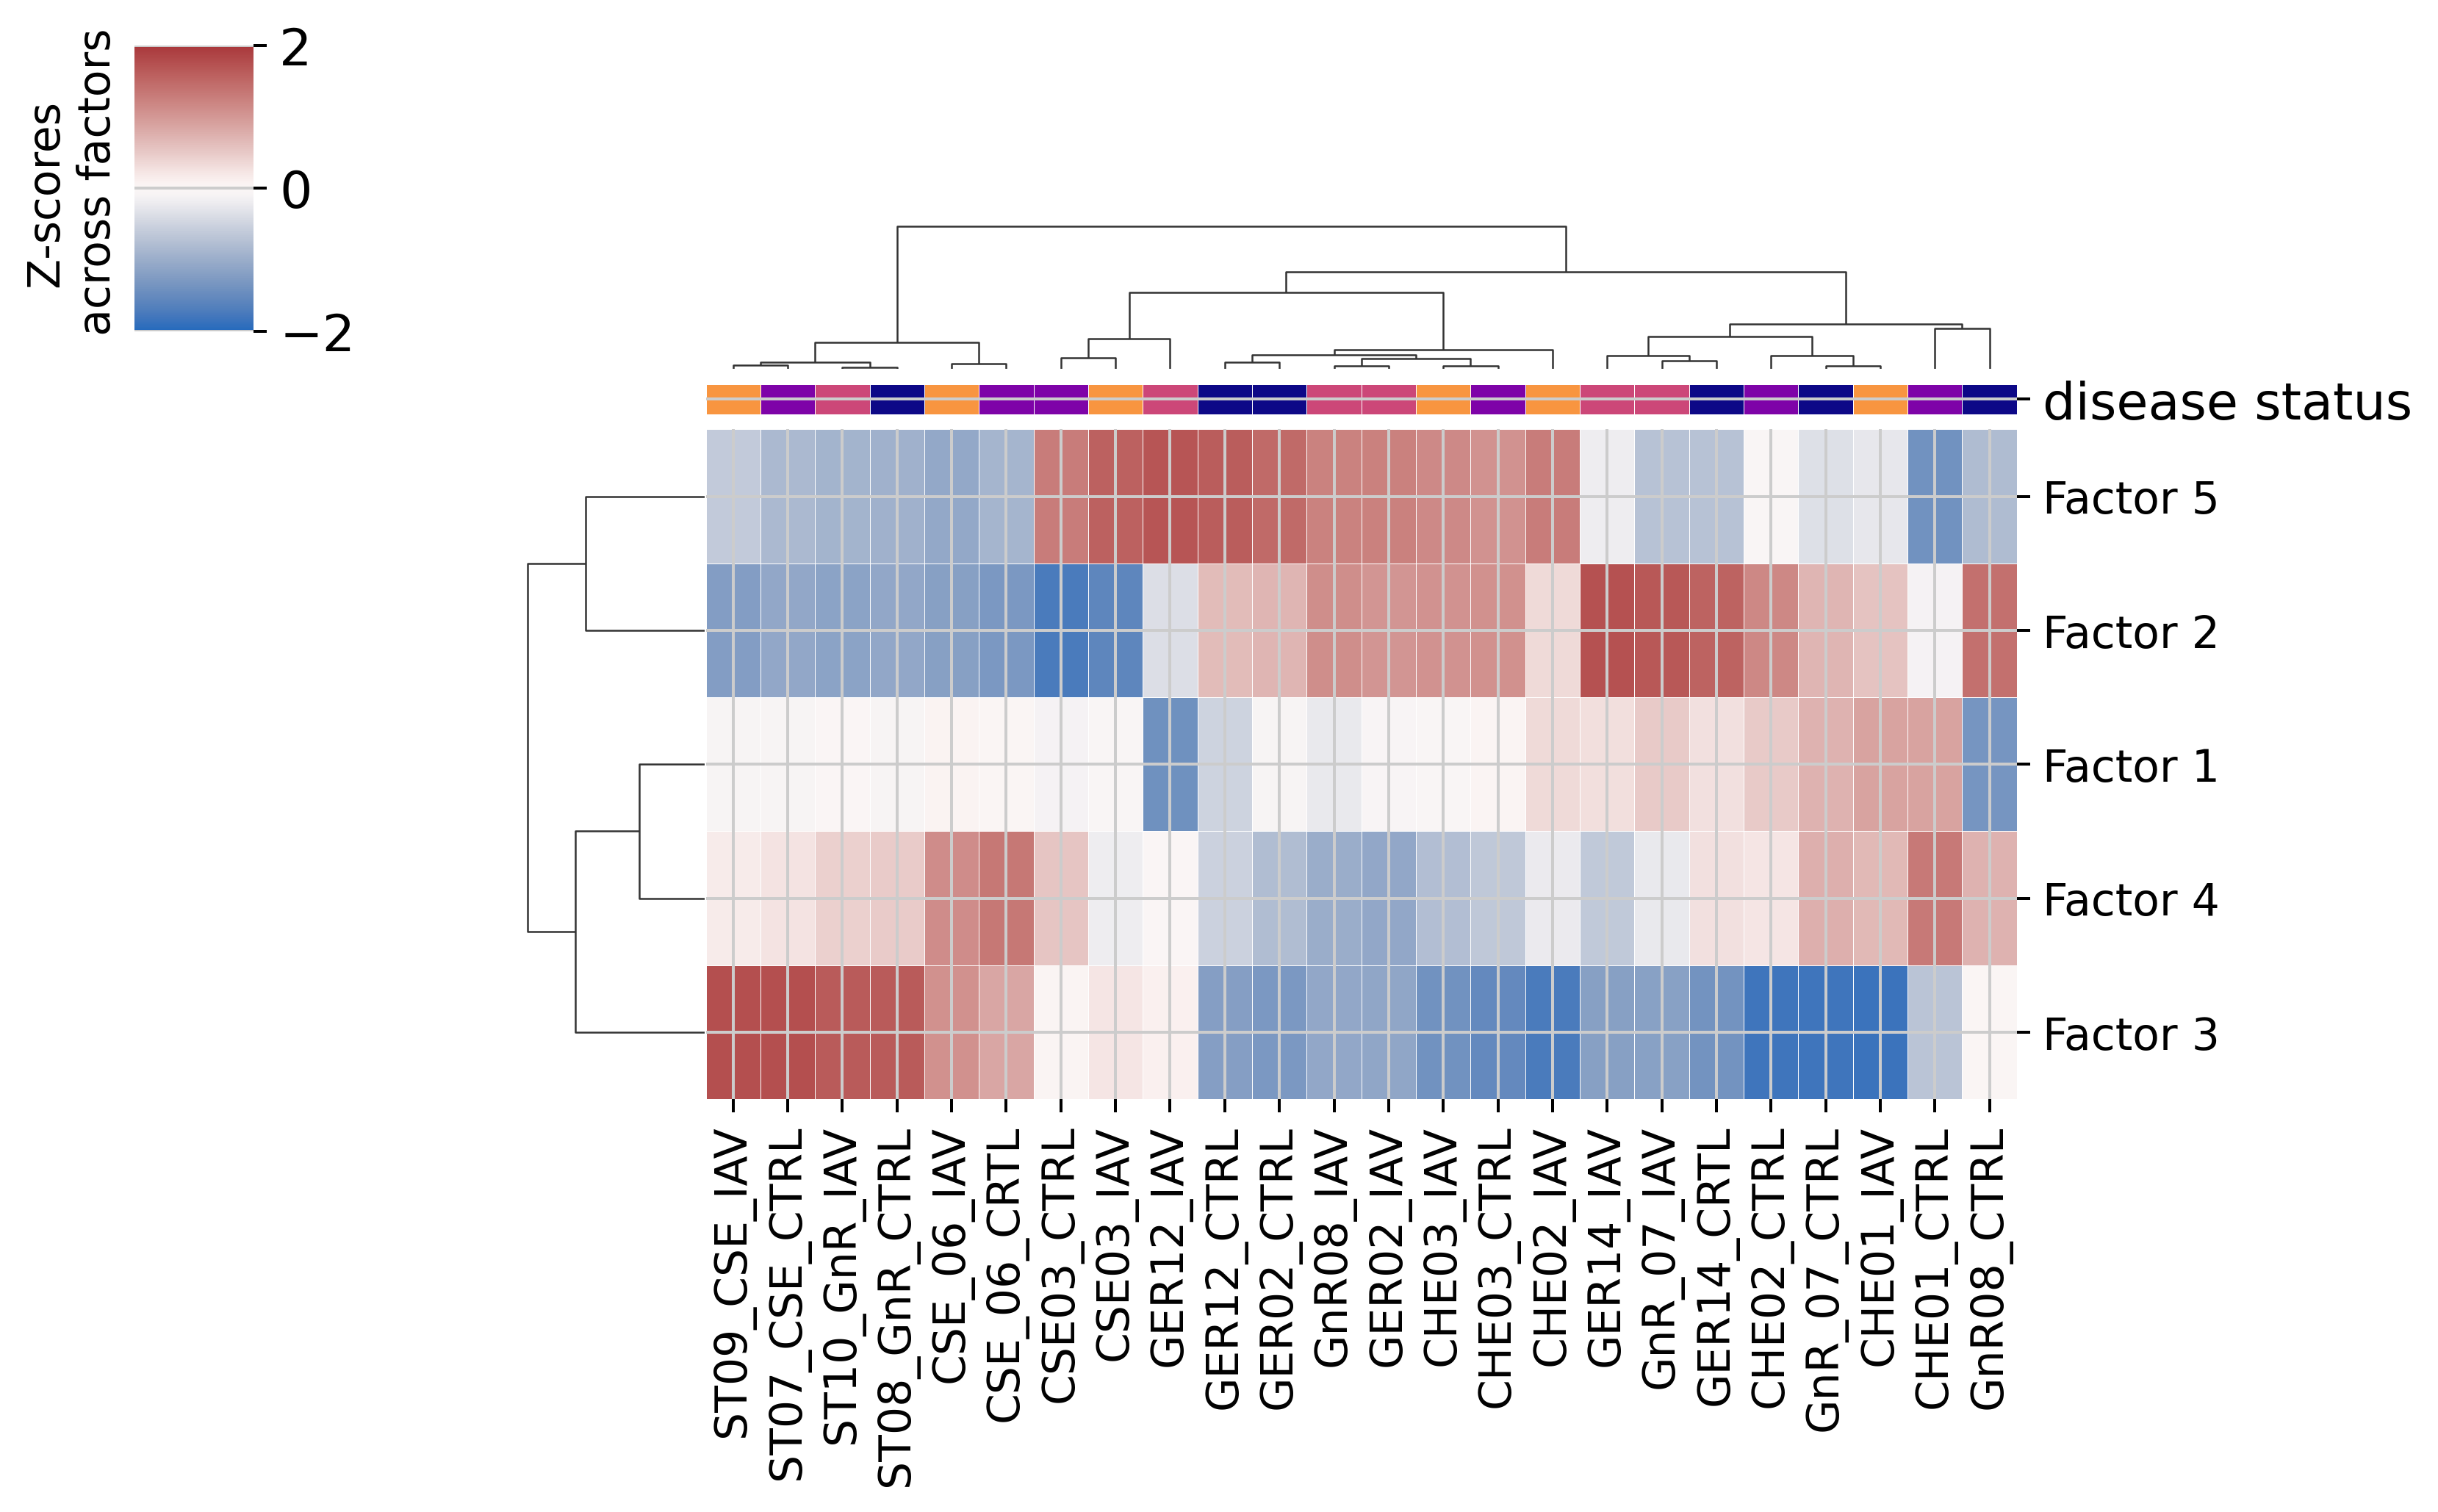

In [15]:
c2c.plotting.loading_clustermap(factors['Contexts'],
                                use_zscore=True, # Whether standardizing the loadings across factors
                                col_colors=col_colors, # Change this to color by other properties
                                figsize=(9, 6),
                                dendrogram_ratio=0.3,
                                cbar_fontsize=12,
                                tick_fontsize=12
                                )

(<Figure size 1440x2160 with 8 Axes>,
 array([[<Axes: title={'center': 'Factor 1'}, ylabel='Context Loadings'>,
         <Axes: title={'center': 'Factor 2'}, ylabel=' '>],
        [<Axes: title={'center': 'Factor 3'}, ylabel='Context Loadings'>,
         <Axes: title={'center': 'Factor 4'}, ylabel=' '>],
        [<Axes: title={'center': 'Factor 5'}, ylabel='Context Loadings'>,
         <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

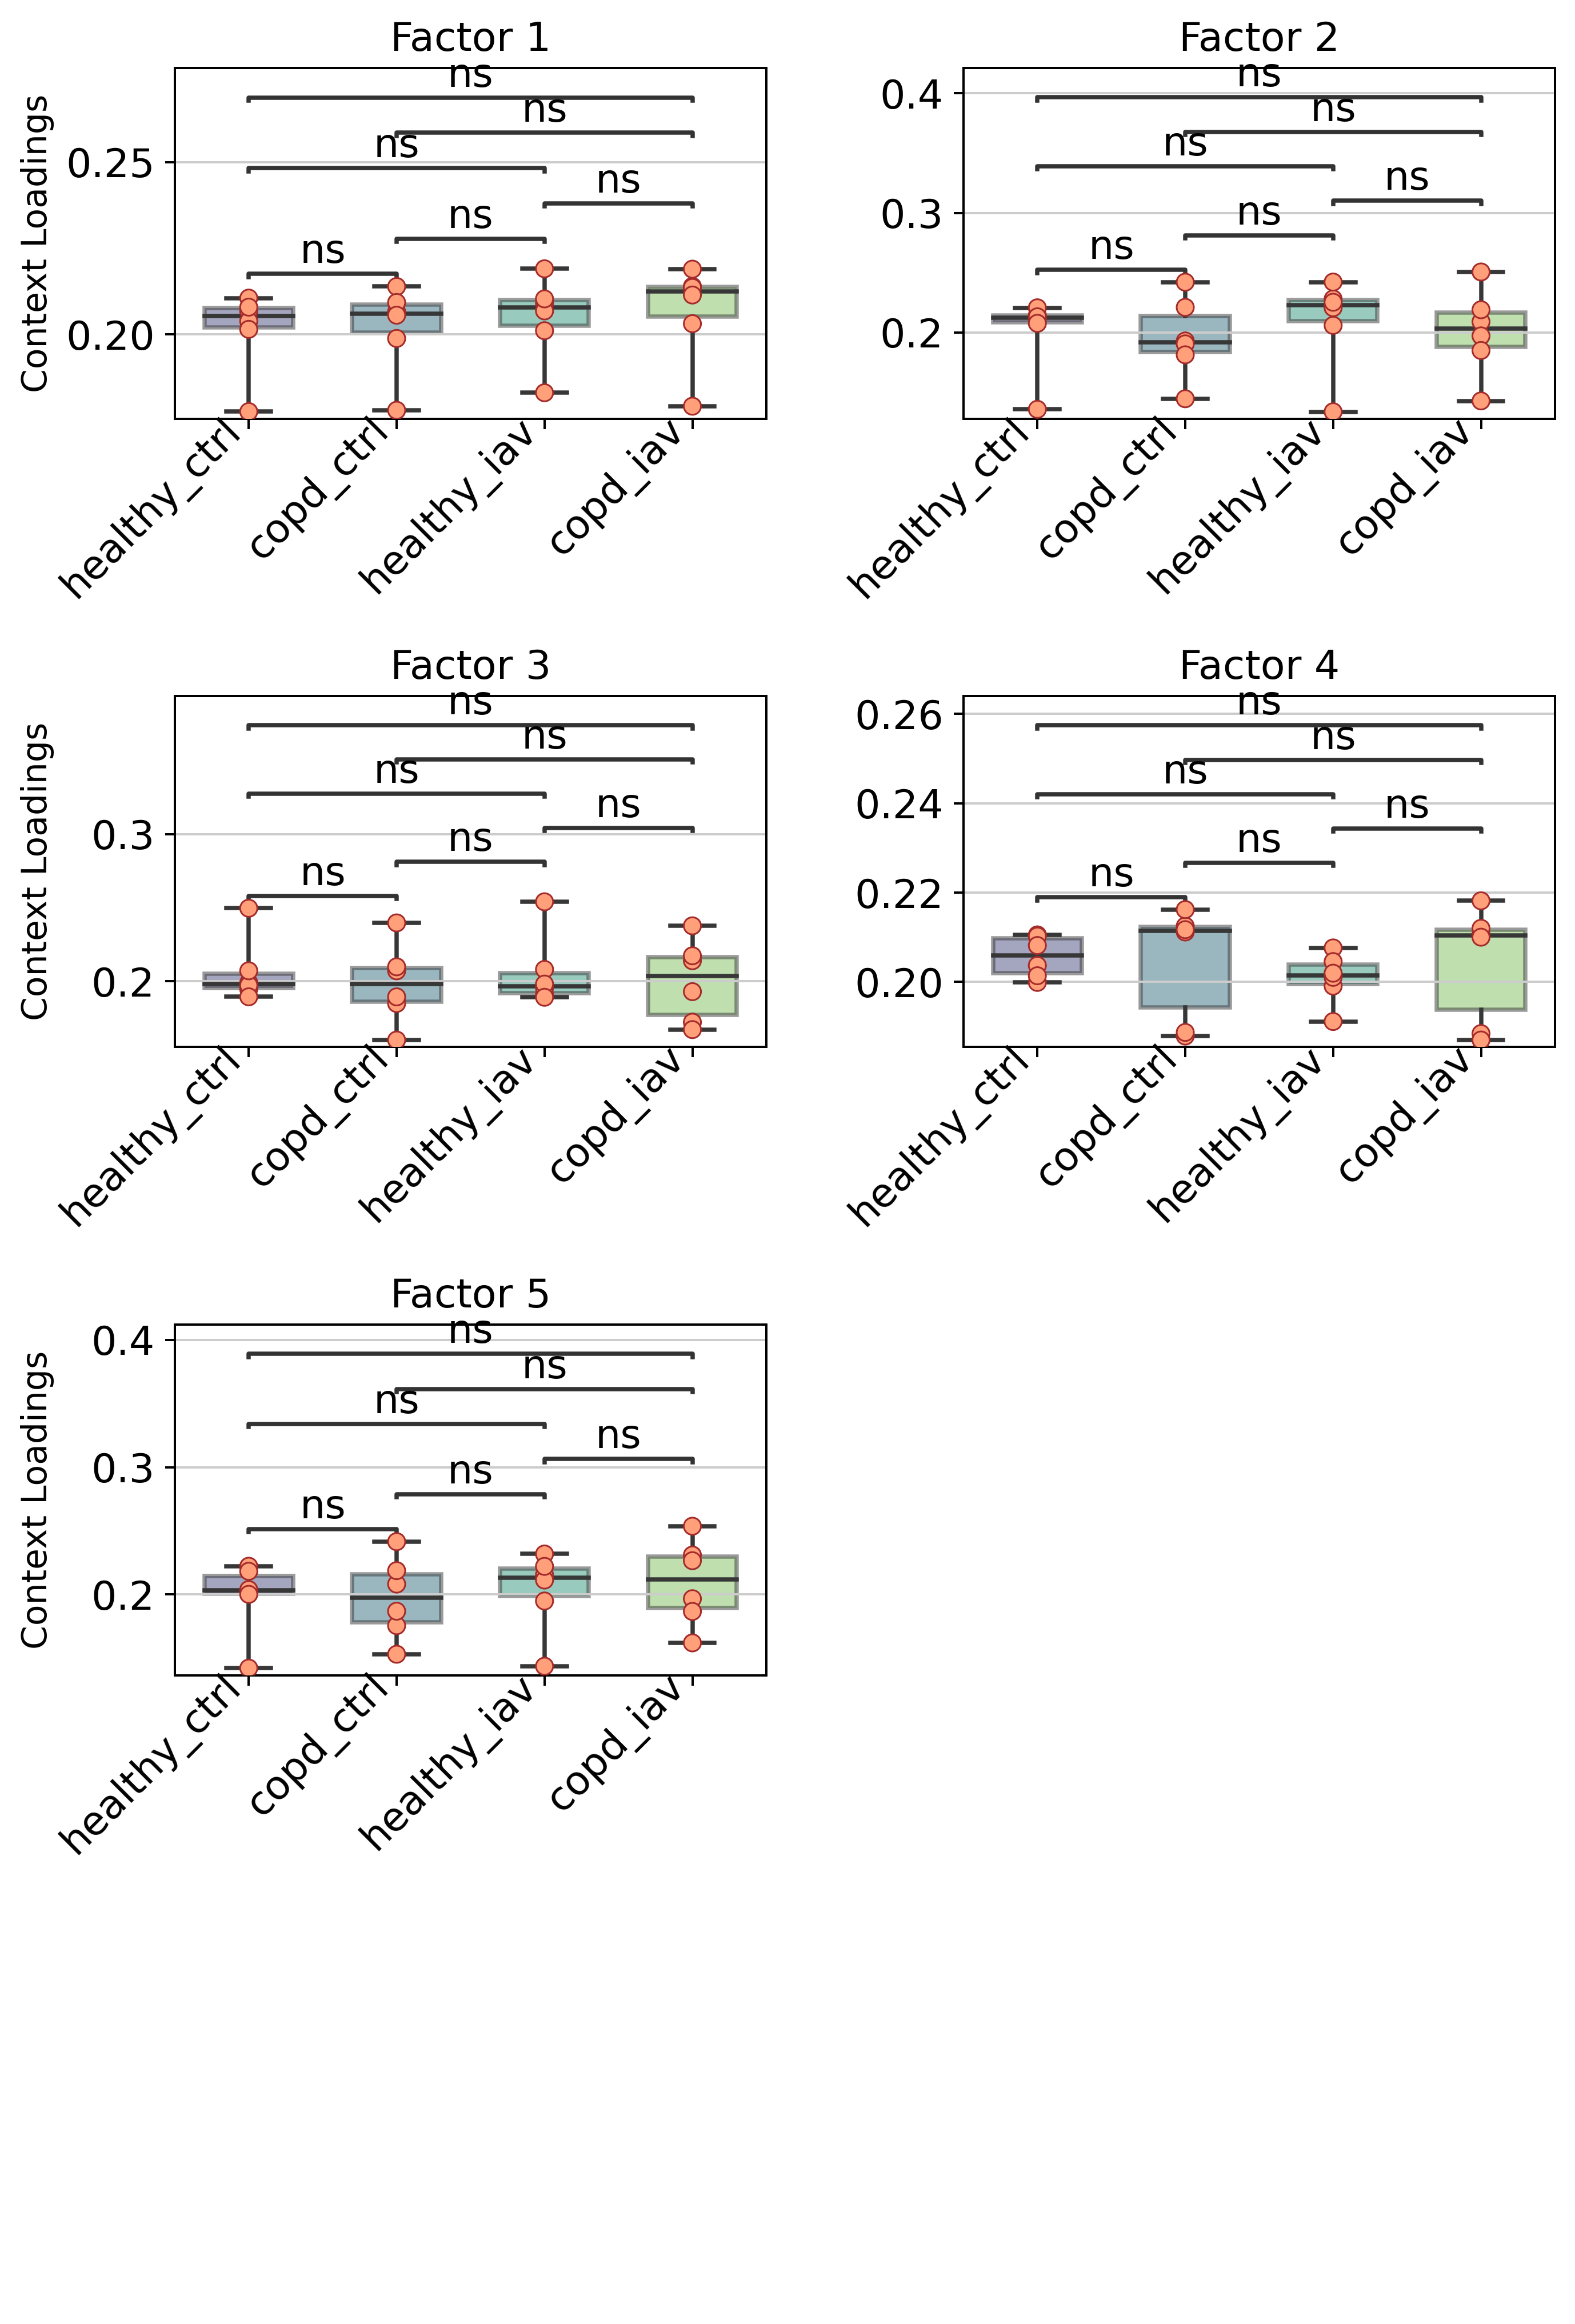

In [16]:
c2c.plotting.factor_plot.context_boxplot(factors['Contexts'],
                            metadict=context_dict,
                            group_label_rotation= 45,
                            nrows=4,
                            figsize=(8, 12),
                            group_order=['healthy_ctrl', 'copd_ctrl', 'healthy_iav', 'copd_iav'],
                            statistical_test='Kruskal',
                            pval_correction="bonferroni",
                            verbose=False,
                            cmap='viridis',
                            ylabel="Context Loadings"
                            )

(<Figure size 2880x4320 with 6 Axes>,
 array([[<Axes: title={'center': 'Factor 1'}>,
         <Axes: title={'center': 'Factor 2'}>],
        [<Axes: title={'center': 'Factor 3'}>,
         <Axes: title={'center': 'Factor 4'}>],
        [<Axes: title={'center': 'Factor 5'}>, <Axes: >]], dtype=object))

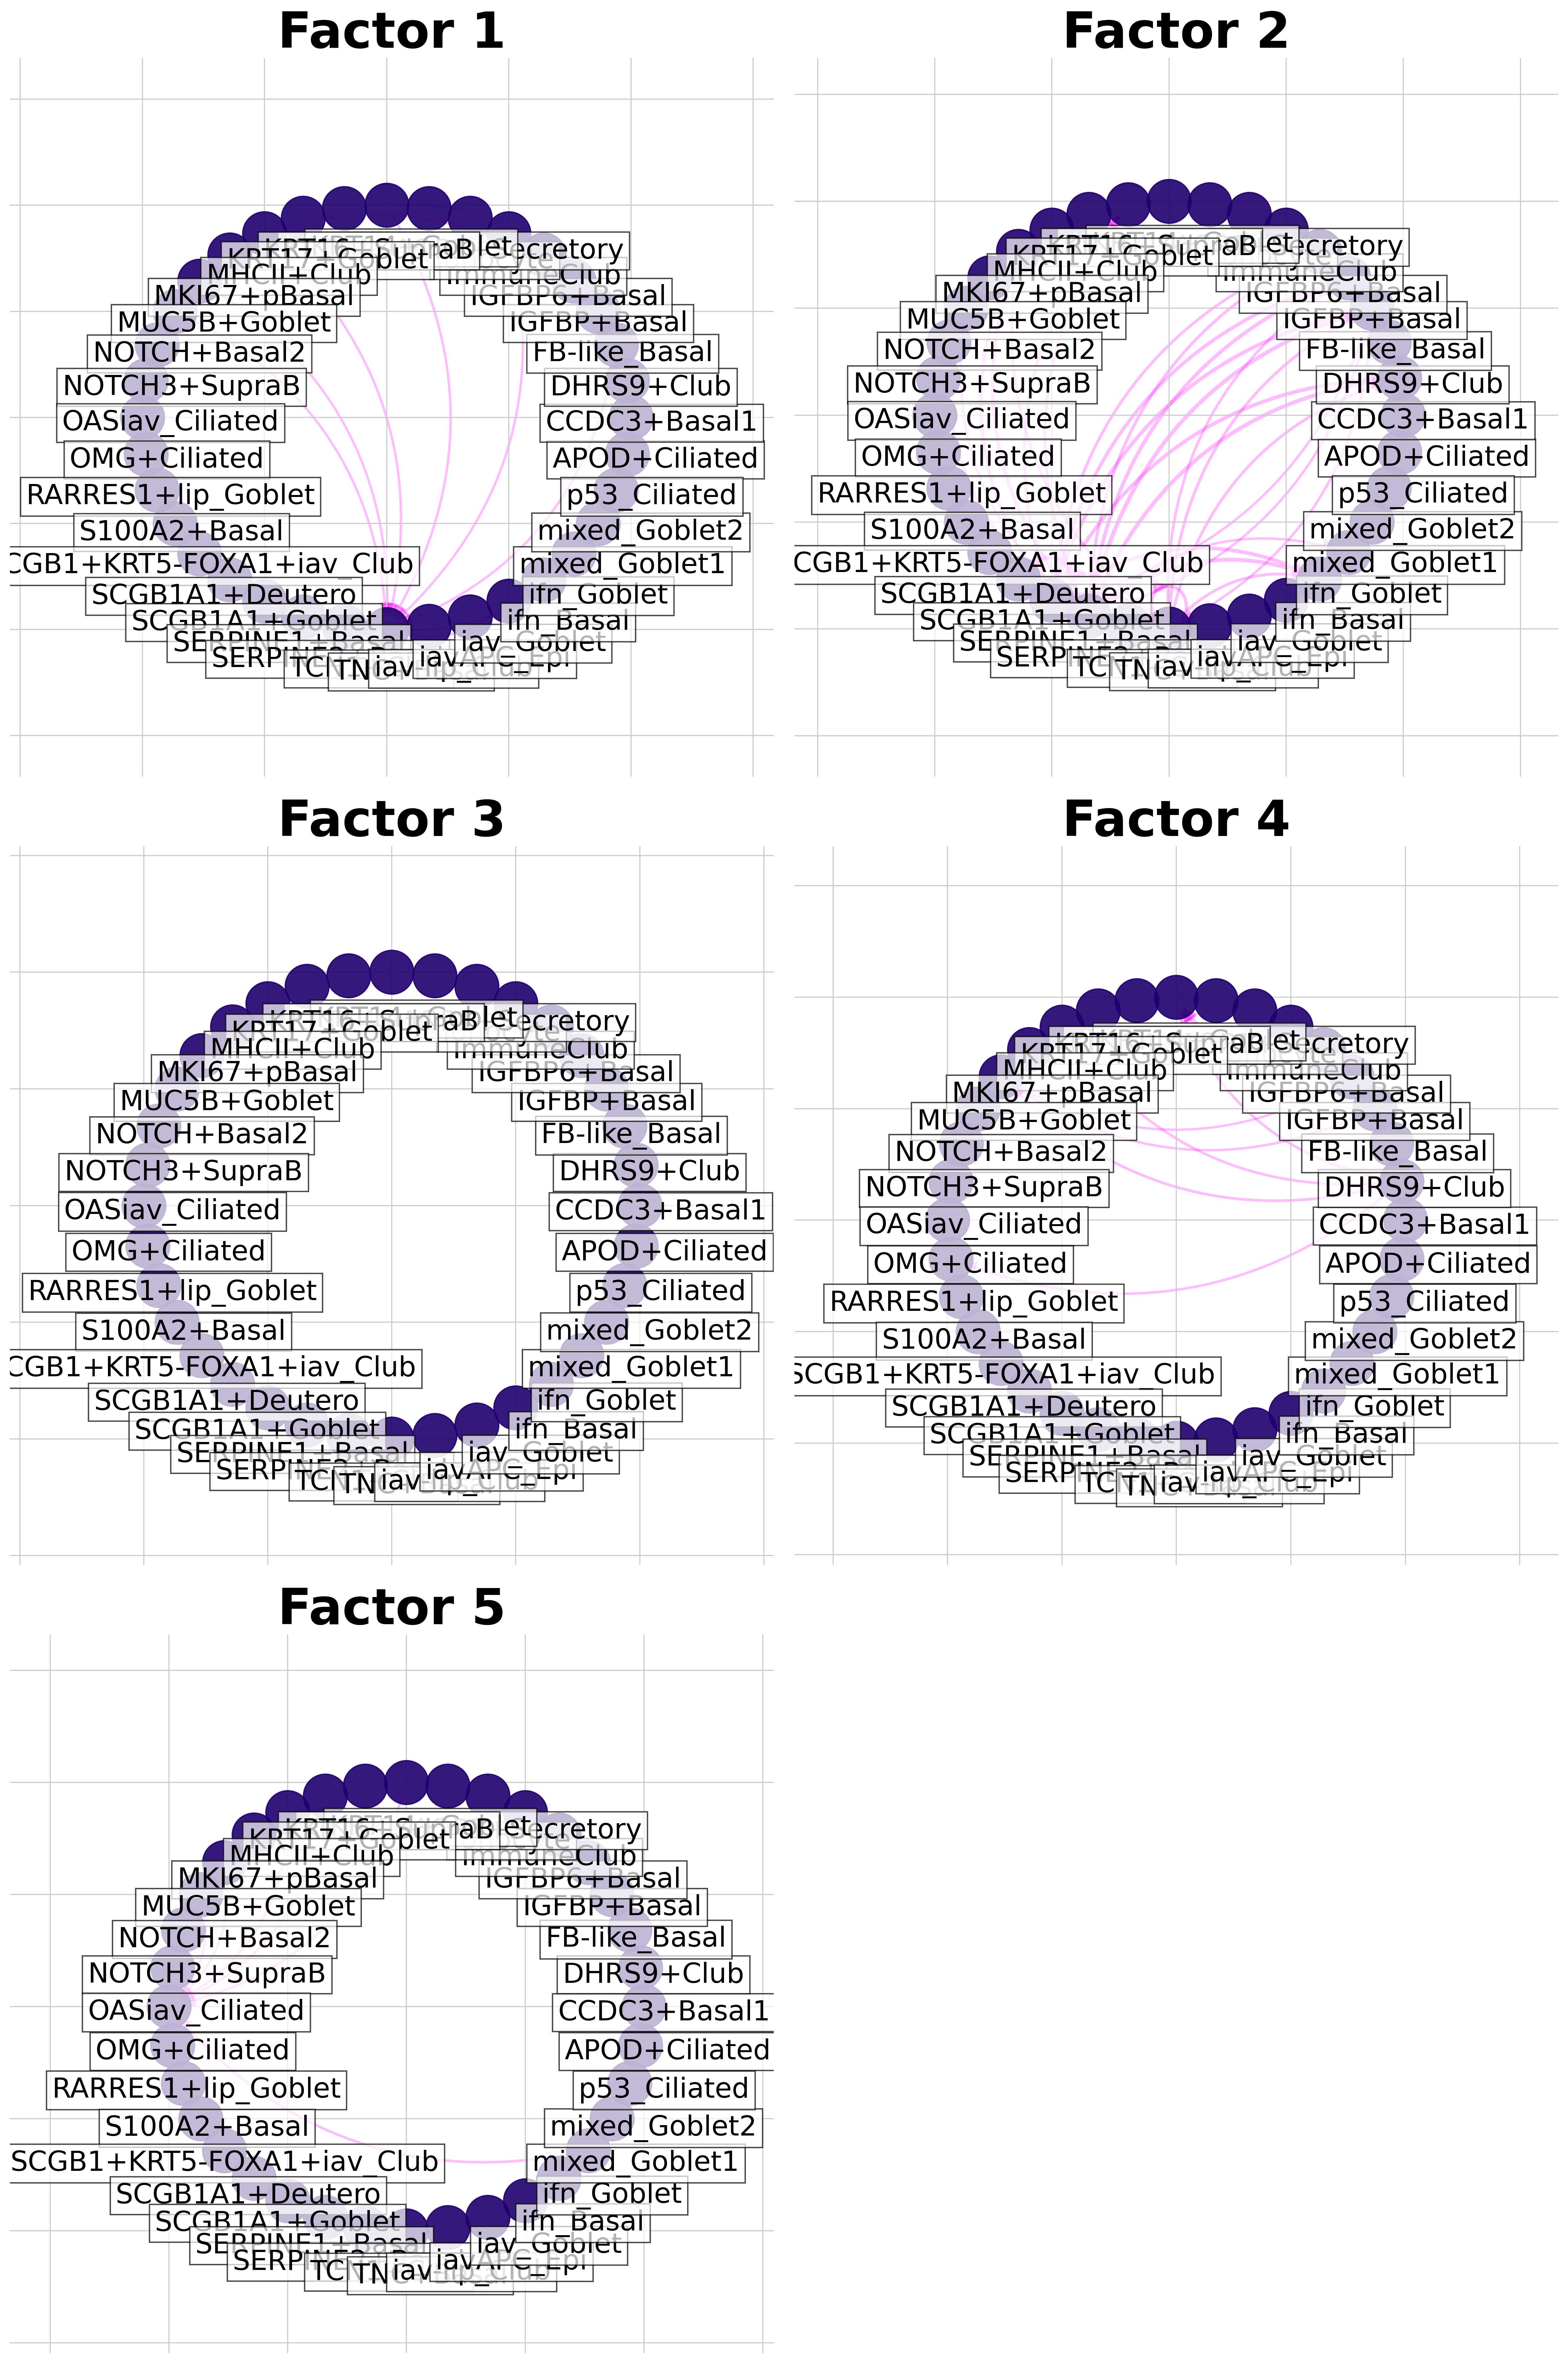

In [17]:
c2c.plotting.ccc_networks_plot(factors,
                               included_factors=['Factor 1','Factor 2', 'Factor 3','Factor 4','Factor 5'],
                               network_layout='circular',
                               ccc_threshold=0.07, # Only important communication
                               nrows=3,
                               panel_size=(8, 8), # This changes the size of each figure panel.
                              )

### Enrichment analysis

In [18]:
lr_loadings = factors['Ligand-Receptor Pairs']

In [19]:
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

In [20]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
lr_progeny.head()

source   interaction    weight
60    JAK-STAT  LGALS9^PTPRC  1.307807
1568  Androgen    SEMA4D^MET -0.831693
1960  Androgen       HGF^MET -1.288956
2352  Androgen     TIMP3^MET -1.122612
3030      NFkB     SELE^CD44  3.332552

In [21]:
# run enrichment analysis
estimate, pvals = dc.run_ulm(lr_loadings.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

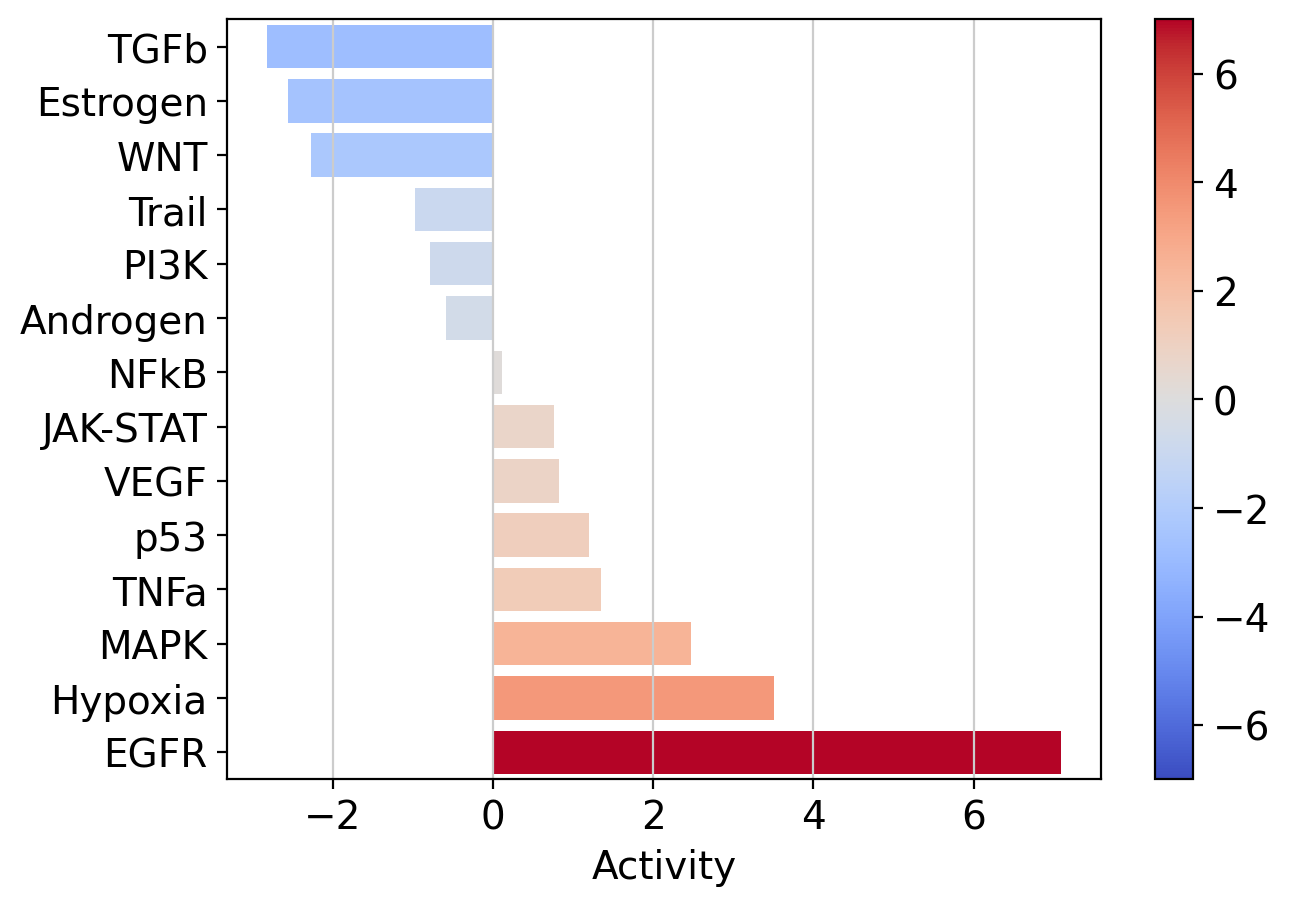

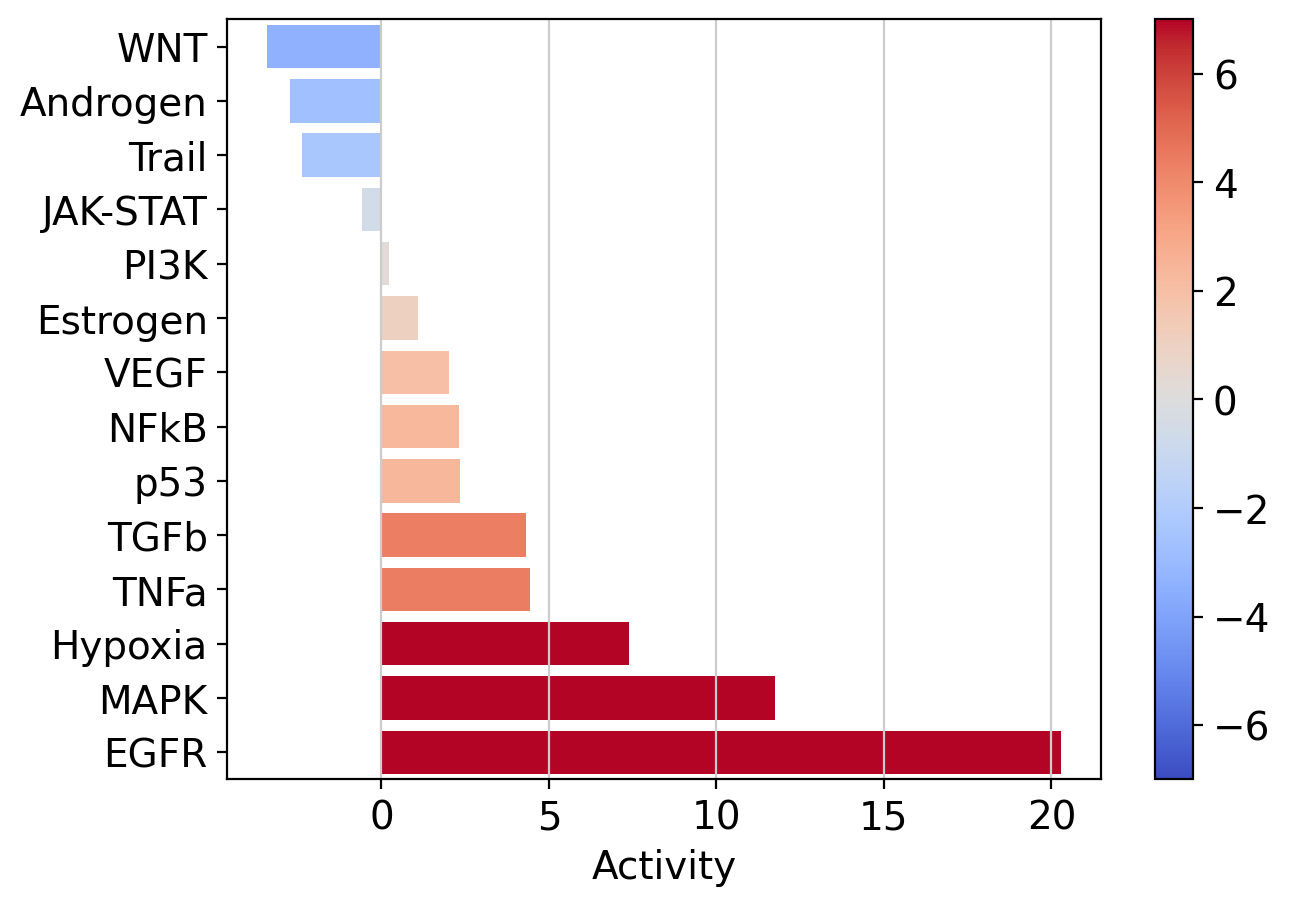

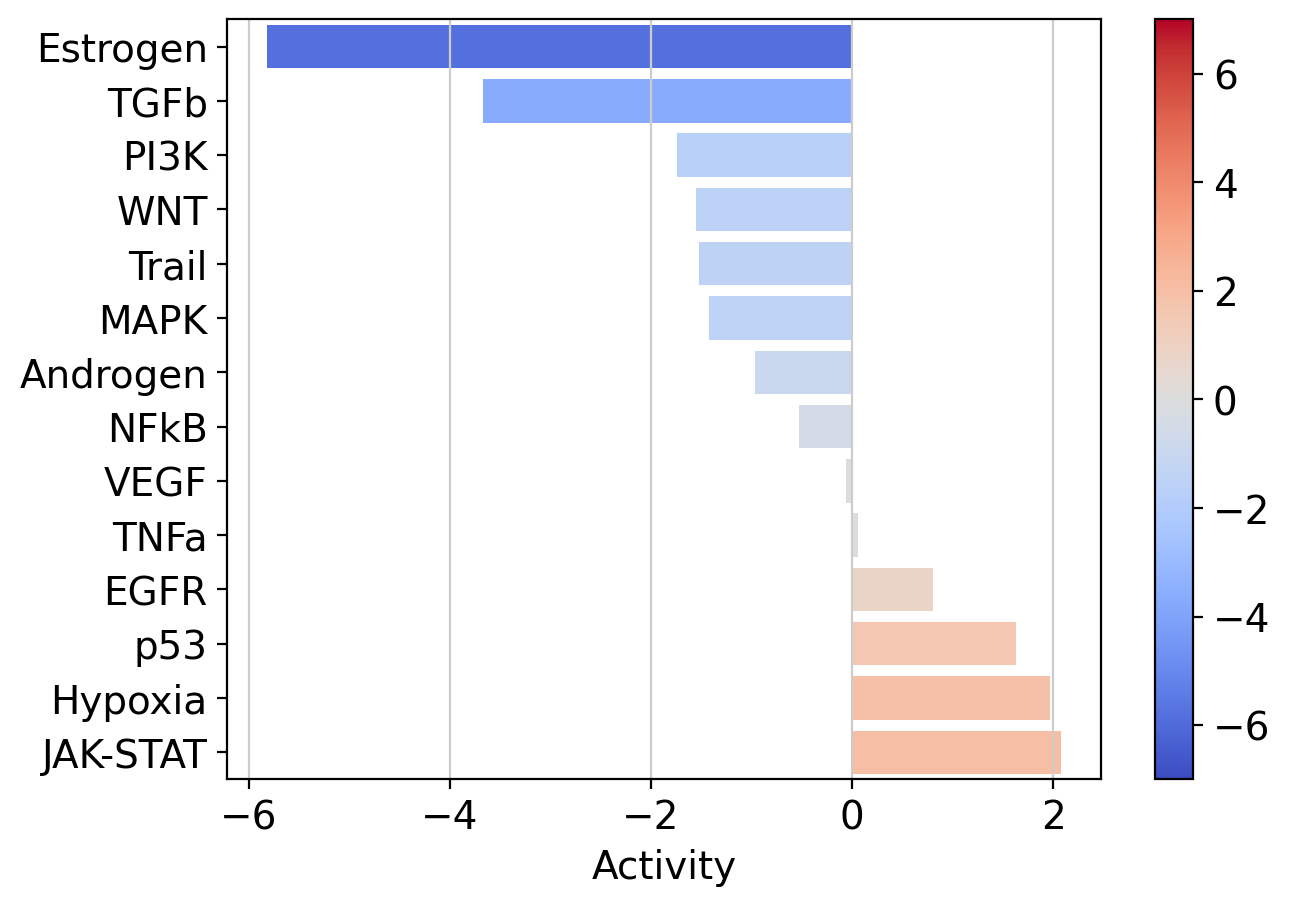

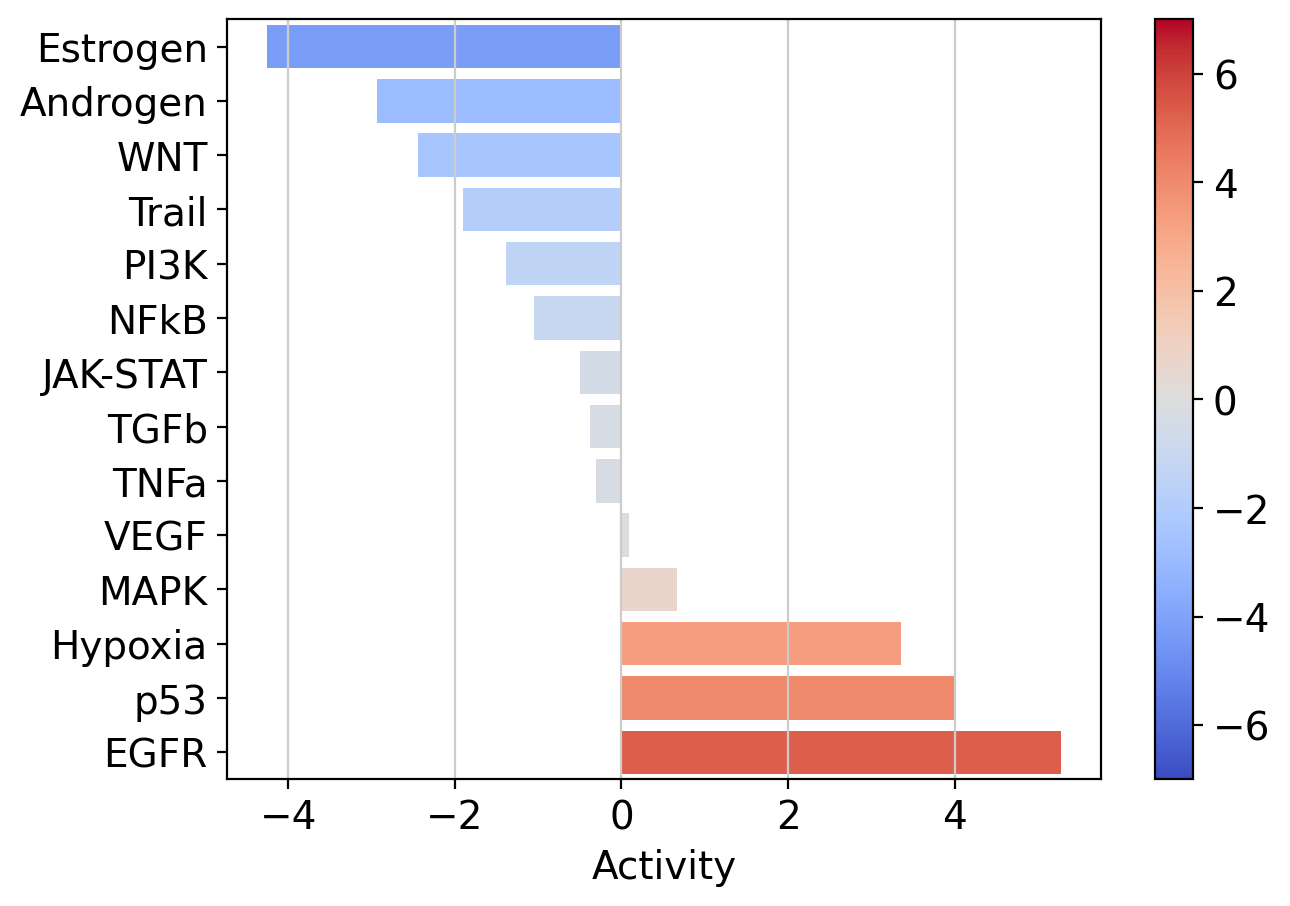

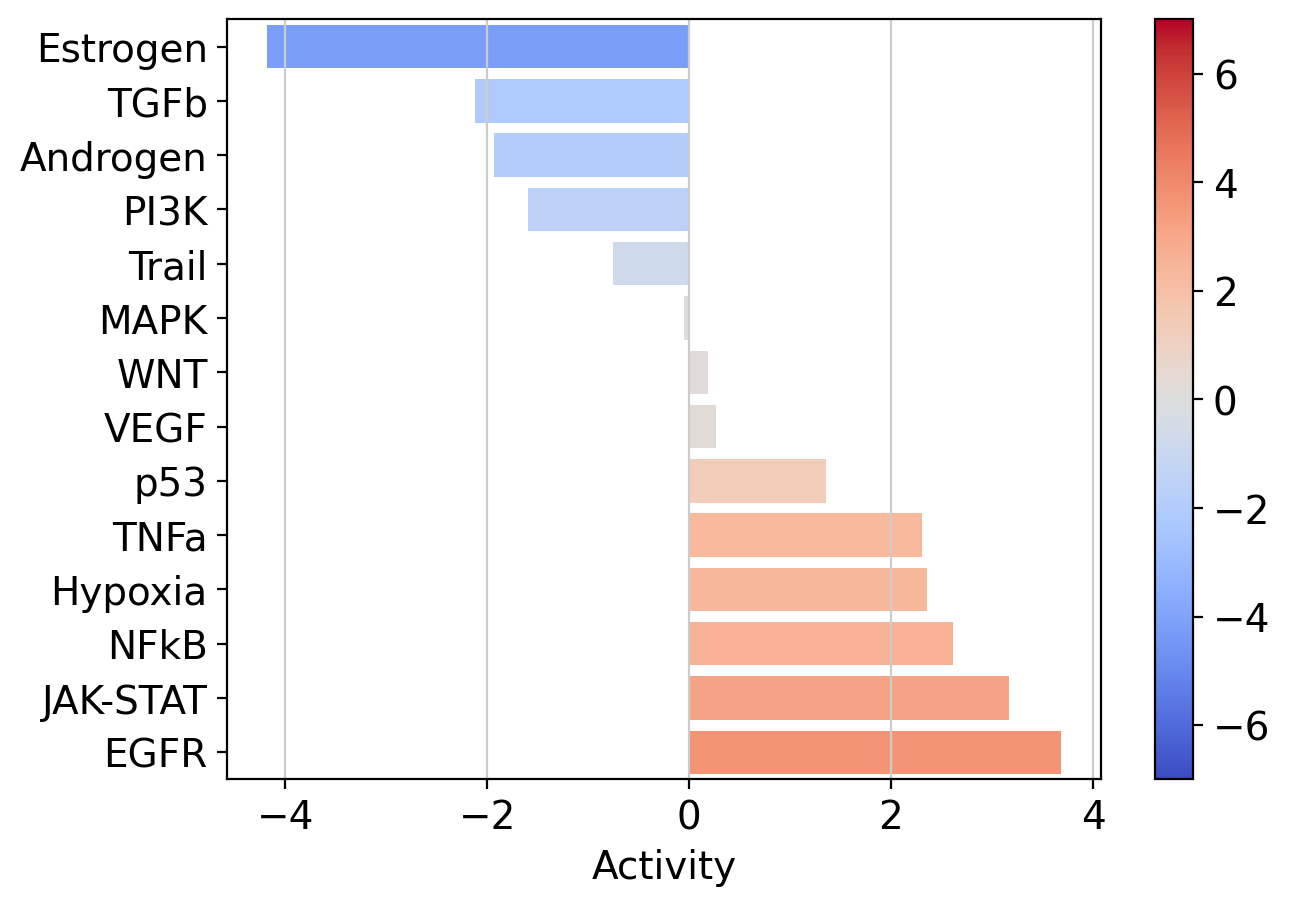

In [22]:
dc.plot_barplot(estimate, 'Factor 1', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
dc.plot_barplot(estimate, 'Factor 2', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
dc.plot_barplot(estimate, 'Factor 3', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
dc.plot_barplot(estimate, 'Factor 4', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
dc.plot_barplot(estimate, 'Factor 5', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)
#dc.plot_barplot(estimate, 'Factor 6', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)

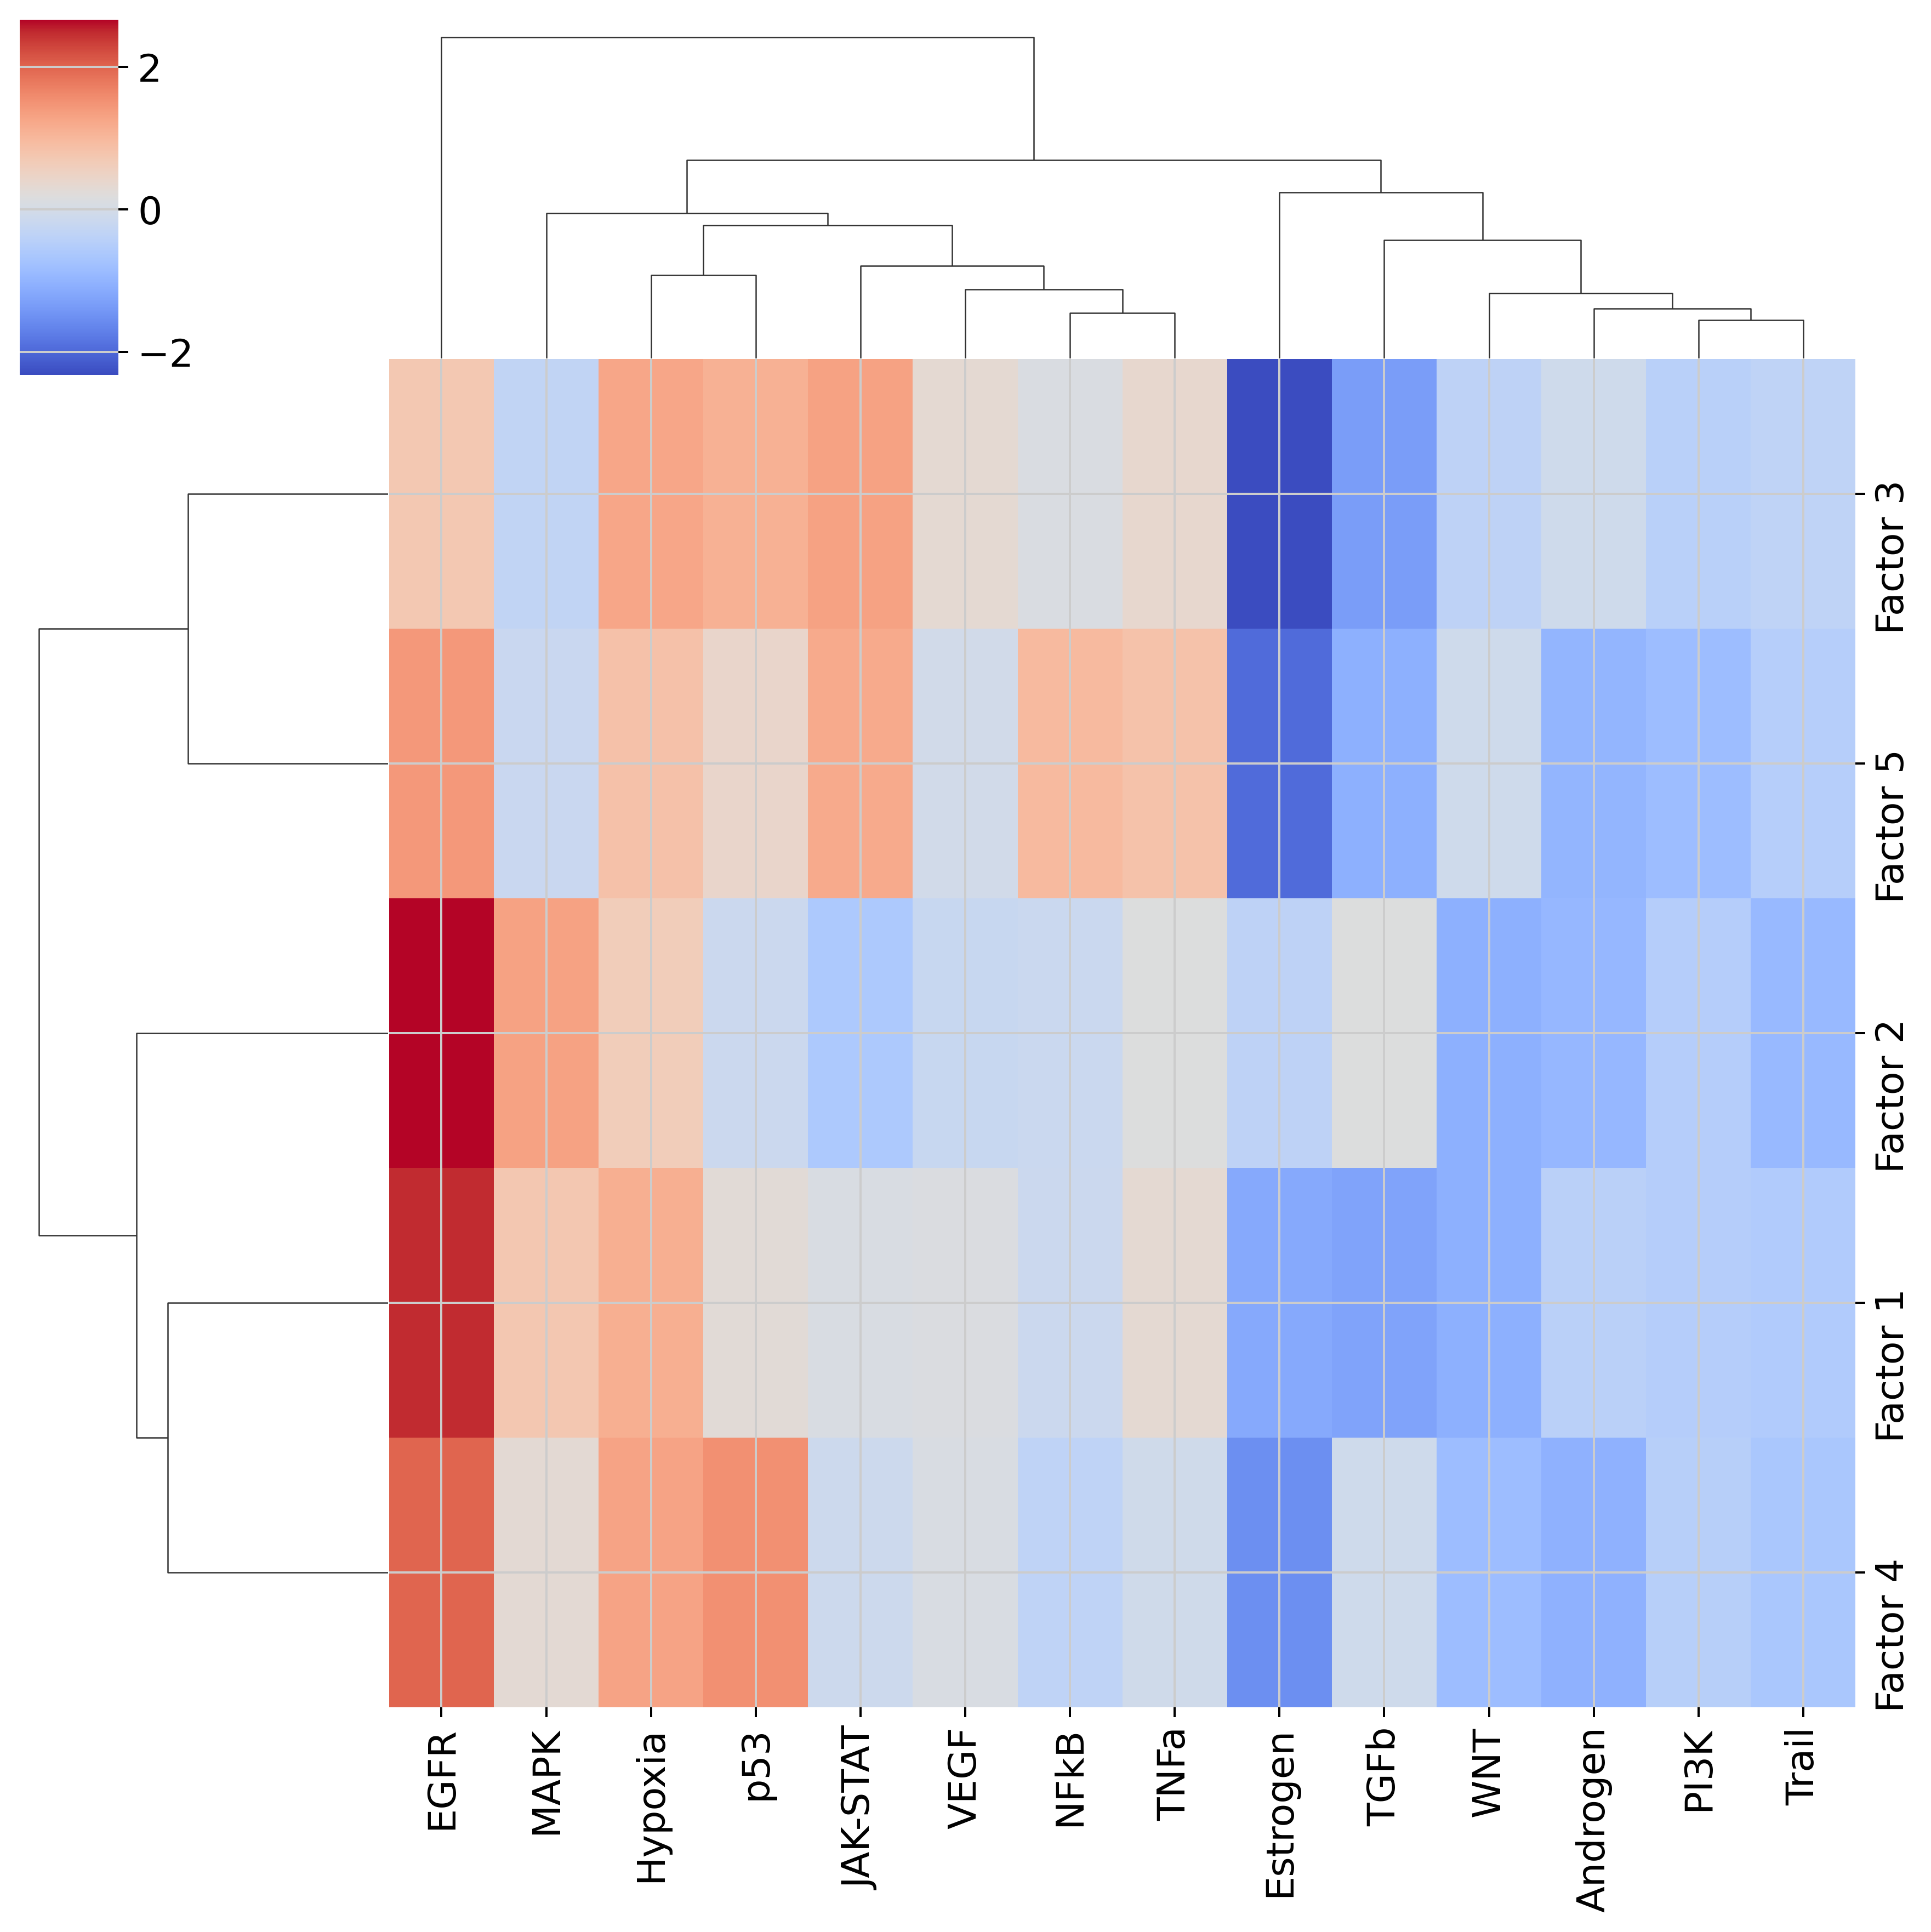

In [23]:
sns.clustermap(estimate, xticklabels=estimate.columns, cmap='coolwarm', z_score=4)

In [26]:
#select factor of interest
selected_factor = 'Factor 2'
#select pathway of interest
pathway = 'EGFR'
# loadings to long format
lr_loadings_long = lr_loadings.reset_index().melt(id_vars='index', var_name="Factor", value_name="Loadings").rename(columns={'index':'interaction'})
# join progeny weights and keep only NFkB pathway
lr_loadings_long = lr_loadings_long.merge(lr_progeny, on='interaction').query("source == '{}' and Factor == '{}'".format(pathway, selected_factor))
# add sign to the weights
lr_loadings_long['sign'] = lr_loadings_long['weight'].apply(lambda x: 'positive' if x > 0 else 'negative')
# keep only relevant interactions for labels
lr_loadings_long['relevant_interactions'] = lr_loadings_long.apply(lambda x: x['interaction'] if (x['Loadings'] > 0.025) and (x['weight'] > 2.5) else None, axis=1)
lr_loadings_long.head()

interaction    Factor  Loadings source    weight      sign  \
1             ACTR2^LDLR  Factor 2  0.037934   EGFR  1.132691  positive   
12          ADAM10^GPNMB  Factor 2  0.034035   EGFR -1.985832  negative   
22         ADAM10^NOTCH1  Factor 2  0.015639   EGFR -0.924934  negative   
42        ADAM10^TSPAN12  Factor 2  0.000205   EGFR -1.275034  negative   
290  ANGPTL4^ITGA5_ITGB1  Factor 2  0.042811   EGFR  2.309002  positive   

    relevant_interactions  
1                    None  
12                   None  
22                   None  
42                   None  
290                  None

/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 15 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_label : Removed 62 rows containing missing values.


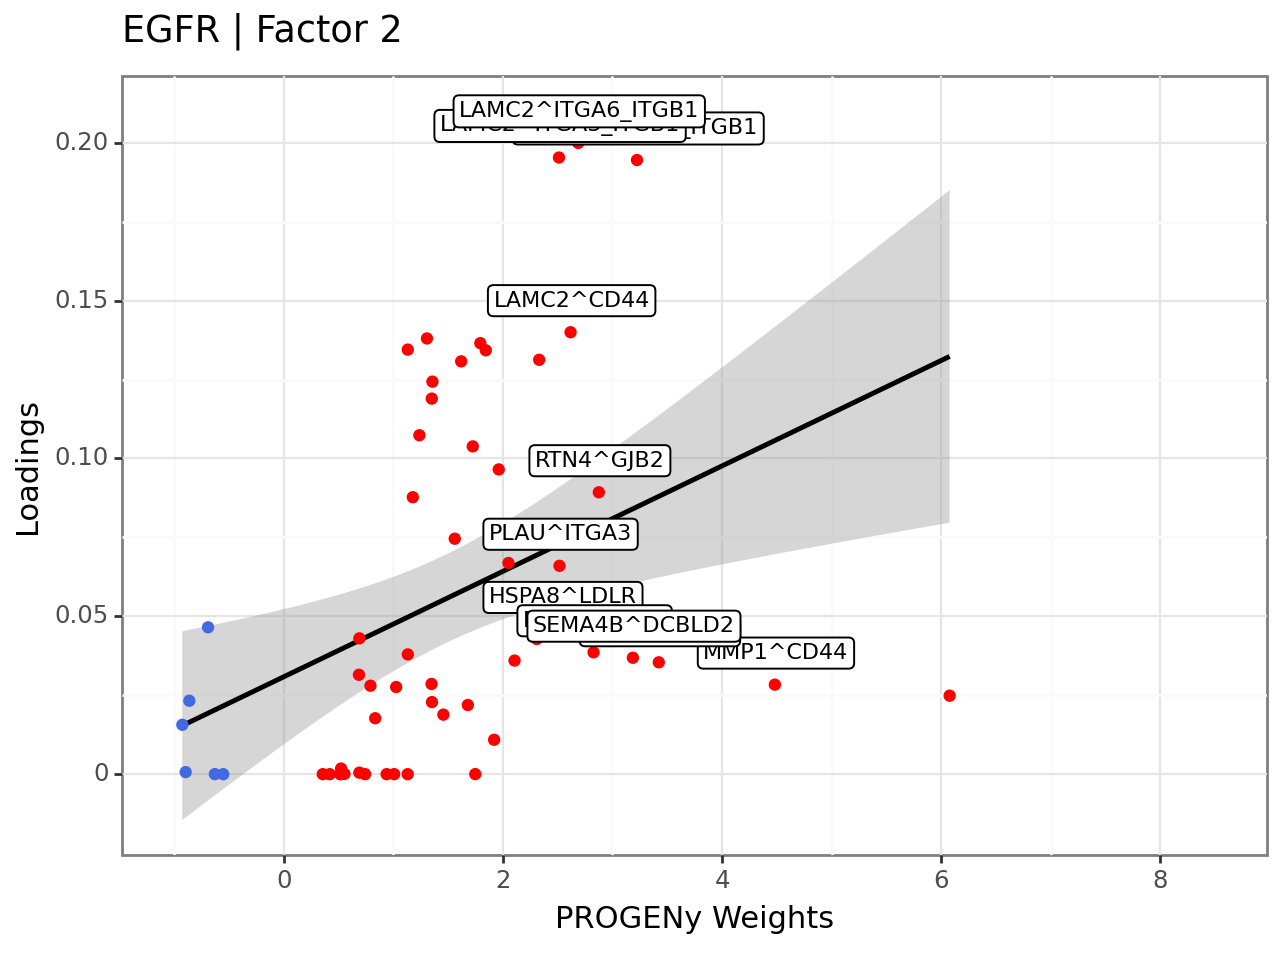

<Figure Size: (640 x 480)>

In [27]:
(p9.ggplot(lr_loadings_long,
           p9.aes(x='weight', y='Loadings')) +
 p9.geom_smooth(method='lm') +
 p9.geom_point(p9.aes(colour='sign')) +
 p9.theme_bw() +
 p9.theme(legend_position='none') +
 p9.labs(title="{} | {}".format(pathway, selected_factor), x="PROGENy Weights", y="Loadings") +
 p9.scale_colour_manual(values=["royalblue", "red"]) +
 p9.geom_label(p9.aes(label='relevant_interactions'), size=8, nudge_y=0.01, nudge_x=0.01) +
 p9.xlim(-1, 8.5)
 )